<a href="https://colab.research.google.com/github/CoskunErden/kaggle/blob/main/kaggle_diabetes_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import os
import pandas_profiling as pp

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline




# Importing the dataset

In [88]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/Datasets/diabetes-2.csv')

# New Section

# Exploratory Data Analysis

In [89]:
print(df.shape)
print(df.info())
print(df.isna().sum())
print(df.head())

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age             

There are 768 observations with 8 features and 1 outcome variable. 

## Examining the features

In [90]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The minimum values observed in Glucose, BloodPressure, SkinThickness, Insulin, and BMI are all zero, which is not a realistic or plausible value. This suggests that these values may be missing or incomplete, and further investigation is required. In addition, 25% of the observations for SkinThickness and Insulin still have a value of 0, which suggests that these two features may have a significant number of missing values that need to be addressed.

## Data Cleaning


### Missing Values

In [91]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace([0], np.nan)

df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [92]:
 df.dropna(subset = ['Glucose', 'BloodPressure', 'BMI'], inplace = True)
 

Any values of 0 will be replaced with NaN, and any rows that have missing values for Glucose, BloodPressure, or BMI features are removed from the dataset. 

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               192
Insulin                     332
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

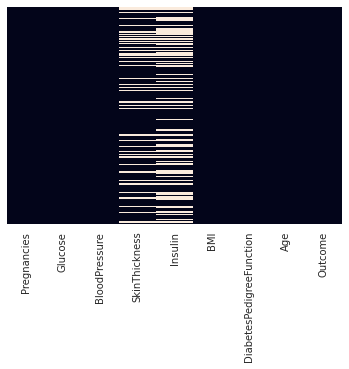

In [93]:
sns.heatmap(df.isnull(),yticklabels= False,cbar = False)
df.isna().sum()

Due to the excessive number of missing values in the insulin variable, it has been decided to exclude it from the data and not utilize it in any models. The missing values in SkinThickness and Insulin will be dealt with after the data has been split into training and testing sets to avoid any data leakage.

### Dropping 'Insulin' and 'DiabetesPedigreeFunction' features from the dataswt

In [94]:
df.drop(['Insulin','DiabetesPedigreeFunction'], axis =1,inplace = True)

### Examining the outliers

In [95]:
df.var()

Pregnancies       11.308443
Glucose          945.564344
BloodPressure    153.261189
SkinThickness    110.752004
BMI               47.457507
Age              138.424467
Outcome            0.225952
dtype: float64

<AxesSubplot:xlabel='value', ylabel='variable'>

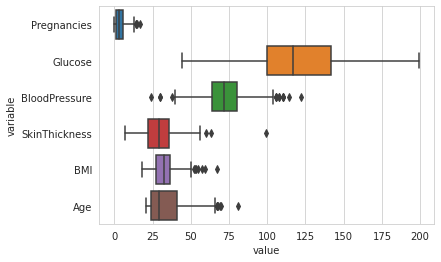

In [96]:
sns.boxplot(y="variable", x="value", data=pd.melt(df.iloc[:,:-1]))

In [97]:
print(df.columns)

for col in ['SkinThickness', 'Glucose', 'BloodPressure',  'BMI']:
    q75,q25 = np.percentile(df.loc[:,col],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    df.loc[df[col] < min,col] = -10000
    df.loc[df[col] > max,col] = 10000



Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI',
       'Age', 'Outcome'],
      dtype='object')


Outliers that are located 1.5 times the interquartile range (IQR) distance from the 25th and 75th percentile are considered outliers and will be removed from the dataset.

In [98]:
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,Outcome
count,724.000000,724.000000,724.000000,532.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,153.585635,29.182331,128.603591,33.350829,0.343923
std,3.362803,30.750030,1384.913155,10.523878,976.062485,11.765393,0.475344
min,0.000000,44.000000,-10000.000000,7.000000,18.200000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,27.500000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,32.400000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,36.000000,36.600000,41.000000,1.000000
max,17.000000,199.000000,10000.000000,99.000000,10000.000000,81.000000,1.000000


The features in the dataset have varying variances, and it is necessary to standardize the data. Since the DiabetesPedigreeFunction feature has a considerably low variance (0.11), it could be reasonable to exclude it from the models. Outliers have been detected in multiple features, including Glucose, BloodPressure, SkinThickness, Insulin, and BMI. These outliers will be removed from the dataset.

In [99]:
df = df[((df['BloodPressure']!=10000) & (df['BloodPressure']!=-10000)) & ((df['BMI']!=10000) & (df['BMI']!=-10000)) & (df['SkinThickness']!=99) ]
df.shape

(704, 7)

<AxesSubplot:xlabel='value', ylabel='variable'>

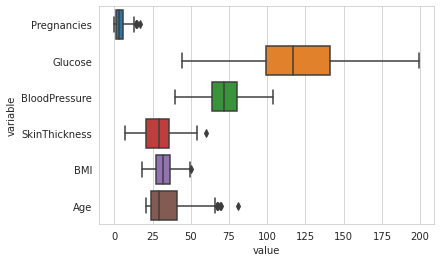

In [100]:
sns.boxplot(y="variable", x="value", data=pd.melt(df.iloc[:,:-1]))

### Examining the correlations among features

<AxesSubplot:>

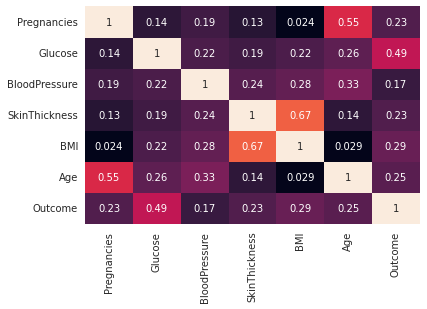

In [101]:
sns.heatmap(df.corr(),annot= True, cbar = False)

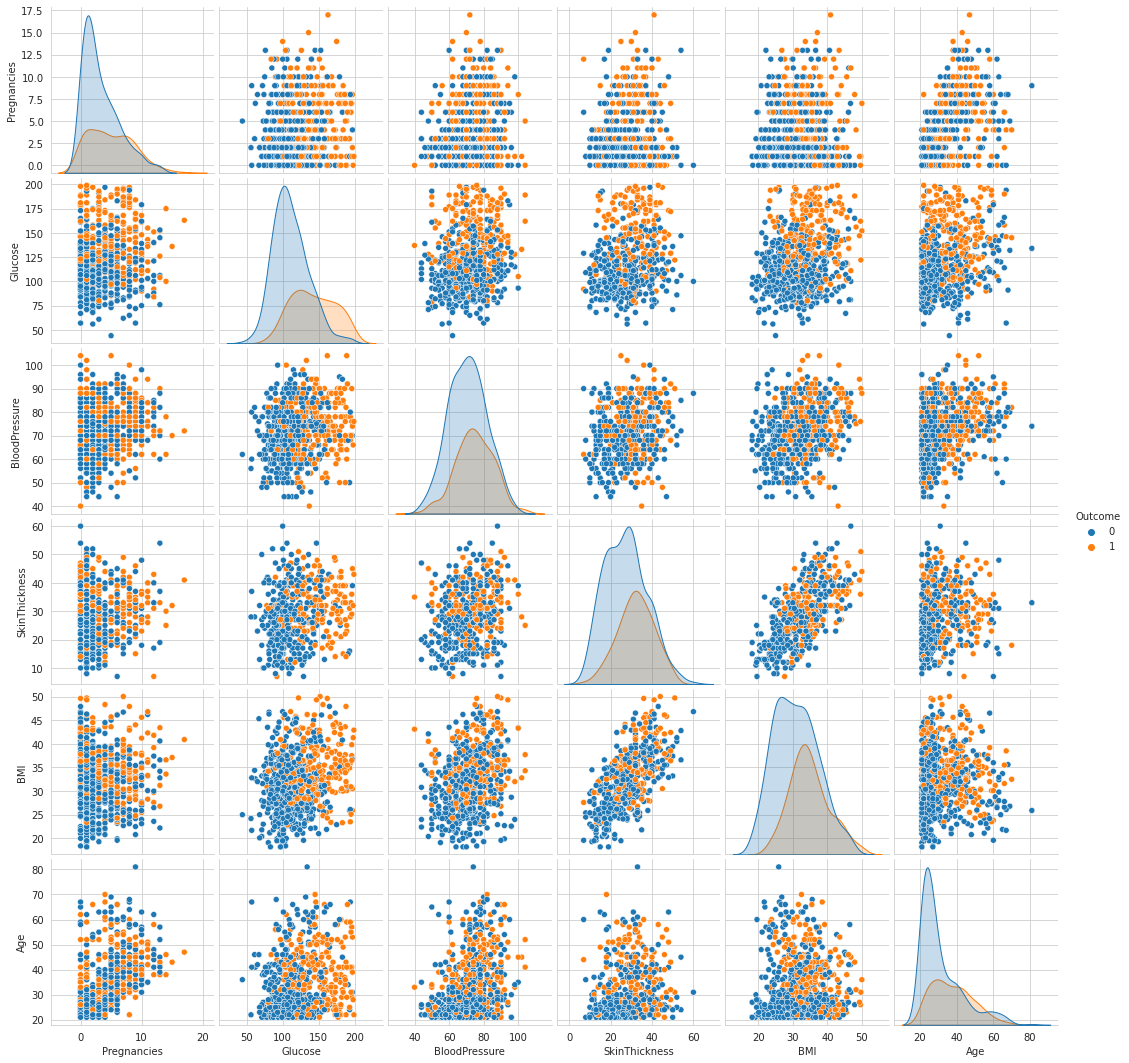

In [102]:
sns.pairplot(df, hue = 'Outcome')

The dataset does not have any highly correlated features, except for SkinThickness and BMI, which have a correlation coefficient of 0.67.  However, there is no requirement to eliminate or merge any of the features to address collinearity.

## Checking class imbalance

0    0.660511
1    0.339489
Name: Outcome, dtype: float64

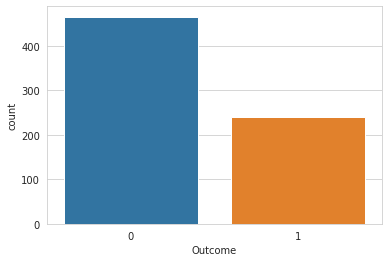

In [103]:


sns.countplot(x= 'Outcome', data = df, order = df['Outcome'].value_counts().index)

df['Outcome'].value_counts(normalize = True)


Even though the observations in the dataset are spread out in different ways, the minority class (1) makes up about 31% of the observations.
This shows that the difference between the classes isn't too big, so there's no need to do anything else to fix it. 

## Splitting Data

In [104]:
df.isna().sum()

Pregnancies        0
Glucose            0
BloodPressure      0
SkinThickness    187
BMI                0
Age                0
Outcome            0
dtype: int64

In [105]:
X = df.drop('Outcome', axis =1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state =123)

### Imputing missing values

In [108]:
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

## Standardizing data

In [112]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test  = std_scaler.transform(X_test)

## Logistic Regression 

In [128]:
logistic=  LogisticRegressionCV(solver='liblinear', penalty = 'l1', cv = 5)

logistic.fit(X_train,y_train)

logistic_predict = logistic.predict(X_test)

logistic_pred_probs = logistic.predict_proba(X_test)[:,1]


### Confusion matrix, classification report, and roc-curve

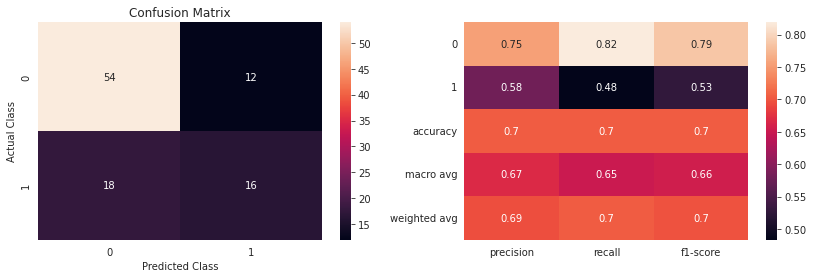

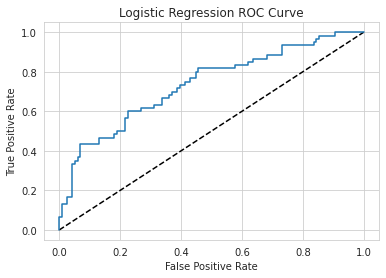

auc_score is: 0.7339080459770115


In [129]:
con_mat = confusion_matrix(y_test,logistic_predict)
plt.figure(figsize=(14,4)) 
plt.subplot(1,2,1)
sns.heatmap(con_mat/np.sum(con_mat)*100,annot =True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(classification_report(y_test,logistic_predict,output_dict=True)).T.iloc[:,:-1], annot = True)

plt.show()

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_pred_probs)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

# roc_auc_score
print('auc_score is:', roc_auc_score(y_test, logistic_pred_probs))


#K-Nearest Neighbors

## Determining the minimum error rate

<AxesSubplot:>

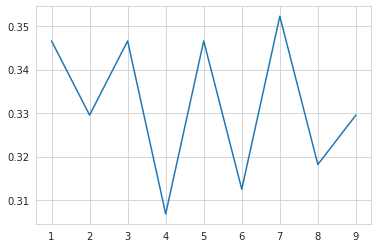

In [141]:
error_rate = []

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred= knn.predict(X_test)
    error_rate.append(np.mean(pred!= y_test))

sns.lineplot(x=range(1,10), y=error_rate, dashes=True)

The value of n_neighbors that generates the lowest error is 4.

In [144]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn_pred_probs = knn.predict_proba(X_test)[:,1]

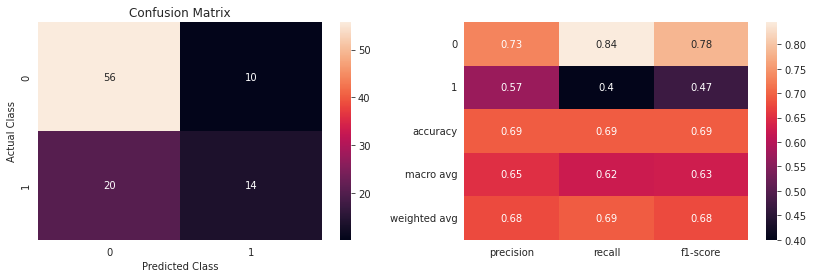

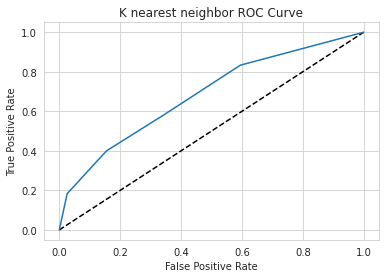

auc_score is: 0.6818247126436782


In [146]:
con_mat = confusion_matrix(y_test,pred)
plt.figure(figsize=(14,4)) 
plt.subplot(1,2,1)
sns.heatmap(con_mat/np.sum(con_mat)*100,annot =True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(classification_report(y_test,pred,output_dict=True)).T.iloc[:,:-1], annot = True)

plt.show()

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn_pred_probs)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K nearest neighbor ROC Curve')
plt.show()

# roc_auc_score
print('auc_score is:', roc_auc_score(y_test, knn_pred_probs))